In [1]:
# =============================================================================
# Import
# =============================================================================

import tensorflow as tf
from keras import backend as K
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import imageio
from PIL import Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import time
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from tensorflow.keras.optimizers import SGD
import scipy.io
from skimage.morphology import disk, dilation, erosion, remove_small_objects, remove_small_holes
from skimage.measure import label, regionprops
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Softmax
import pickle
import random
from scipy.ndimage import binary_dilation, binary_erosion
from scipy.ndimage.morphology import binary_fill_holes, binary_opening
# from skimage.morphology import disk
print('Your imports are available')

2023-07-04 12:01:35.062155: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 12:01:39.908682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Your imports are available


In [2]:
# =============================================================================
# GPU Test
# =============================================================================

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-07-04 12:01:55.165786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-04 12:01:56.759251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-04 12:01:56.760029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

True

In [3]:
# =============================================================================================
# Main code (2) reading images and lables for train and making images and labels folder
# =============================================================================================

img_folder = r'/home/user/Desktop/MandalPaperCodePython/Data/Blk65x65_Seg/Im' 
label_folder =r'/home/user/Desktop/MandalPaperCodePython/Data/Blk65x65_Seg/Lbs'

with open("shuffled_filenames.pickle", "rb") as file:
    img_filenames = pickle.load(file)
print(img_filenames[:5])  


# # Get list of image and label filenames
# img_filenames = sorted(os.listdir(img_folder))
# # label_filenames = sorted(os.listdir(label_folder))

# random.seed(42)
# random.shuffle(img_filenames)
# # random.shuffle(label_filenames)



# print(img_filenames[:5])    
# print(label_filenames[:5])  
# print(img_filenames[5:15])    
# print(label_filenames[5:15]) 

# Load images and labels into numpy arrays
images = []
labels = []
for i, img_filename in tqdm(enumerate(img_filenames)):
    
    # Load image and resize to 65x65
    img = cv2.imread(os.path.join(img_folder, img_filename))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)    
    #img = cv2.resize(img, (65, 65))
    
    # Load corresponding label and convert to one-hot encoding
    
#     label = cv2.imread(os.path.join(label_folder, label_filenames[i]))
    label = cv2.imread(os.path.join(label_folder, img_filename))
    label = cv2.cvtColor(label,cv2.COLOR_BGR2RGB)    
    #label = cv2.resize(label, (65, 65))

    # Append image and label to arrays
    images.append(img)
    labels.append(label) 
   

print ('Your image folder "images" and your labels foldr "labels" are produced')

['Image1.png', 'Image10.png', 'Image100.png', 'Image1000.png', 'Image10000.png']


36736it [00:16, 2203.03it/s]

Your image folder "images" and your labels foldr "labels" are produced


Image filename: Image33316.png
Label filename: Image33316.png


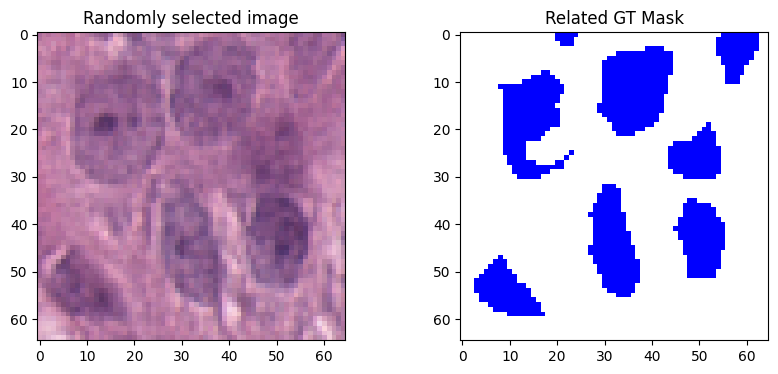

In [4]:
# ===========================================================================================
#  Main code (3) show an image and its mask after imresizing to 65*65, and print pixel values of image and mask   
# ===========================================================================================

image_dataset = np.array(images)
mask_dataset =  np.array(labels)

#Sanity check, view few images
import random
image_number = random.randint(0, len(image_dataset))

# Print corresponding image and label filenames
print("Image filename:", img_filenames[image_number])
print("Label filename:", img_filenames[image_number])

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title('Randomly selected image')
plt.imshow(np.reshape(image_dataset[image_number], (65, 65, 3)))
plt.subplot(122)
plt.title('Related GT Mask')
plt.imshow(np.reshape(mask_dataset[image_number], (65, 65,3)))
plt.savefig(r'/home/user/Desktop/MandalPaperCodePython/Results/Im&Mask.jpg',dpi=300)
plt.show()

# Convert the mask array to a list and print it
mask_value = labels[image_number].tolist()
# print(mask_value)    
image_value = image_dataset[image_number].tolist()
# print(image_value)    

In [5]:
# =============================================================================
# Convert RGB Masks to 2D labels (0=Melanoma,1=Non_melanoma,2=Background)
# =============================================================================

#Call "rgb_to_2D_label" function
%run rgb_to_2D_label.ipynb

labels_ctg = []
for i in tqdm(range(mask_dataset.shape[0])):
#     label = mask_dataset[i]
    label = rgb_to_2D_label(mask_dataset[i])
    labels_ctg.append(label)    

labels_ctg = np.array(labels_ctg)   
labels_ctg = np.expand_dims(labels_ctg, axis=3)

# print number of classes and their values
n_classes = len(np.unique(labels_ctg))
print ("Number of different classes in labels are:", n_classes)
print("Unique values of labels are:", np.unique(labels_ctg))

#Convert to categorical
labels_cat = to_categorical(labels_ctg, num_classes=n_classes)


"rgb_to_2D_label" function is called


100%|███████████████████████████████████| 36736/36736 [00:13<00:00, 2681.70it/s]


Number of different classes in labels are: 3
Unique values of labels are: [0 1 2]


In [6]:
# =============================================================================
# Split the data into train and test sets (70% train, 30% validation & test)
# =============================================================================

# Split the data set into train and (test&validation) sets (70% train, 30% (test&validation)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size=0.3, random_state=42)

# Split the (test&validation) set into validation and test sets (50% validation, 50% test)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("Image heigt=",X_train.shape[1])
print("Image width=",X_train.shape[2])
print("Image channels=",X_train.shape[3])

Image heigt= 65
Image width= 65
Image channels= 3


In [7]:
# =============================================================================
# Defining model
# =============================================================================

#Call model (Unet, DeepCNNmodel_Modified) function
# %run Unet_model.ipynb
%run DeepCNNmodel_Modified.ipynb

model=DeepCNNmodel_Modified()
#model = DeepCNNmodel_Modified_64size(None)
#model = Unet_model_64size()       #64*64 
# model = Unet_model()                #65*65

2023-07-04 12:03:05.290080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-04 12:03:05.290756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-04 12:03:05.291257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(None, 64, 64, 64) relu1_1 shape after passing conve 2*2
(None, 64, 64, 64) D1_1 shape after passing conve 2*2
(None, 64, 64, 64)
(None, 65, 65, 192)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 I1 (InputLayer)                [(None, 65, 65, 3)]  0           []                               
                                                                                                  
 Conv1_1 (Conv2D)               (None, 65, 65, 64)   1792        ['I1[0][0]']                     
                                                                                                  
 B1_1 (BatchNormalization)      (None, 65, 65, 64)   256         ['Conv1_1[0][0]']                
                                                                                                  
 relu1_1 (Activation)           (None, 65, 

                                                                                                  
 relu2_5 (Activation)           (None, 8, 8, 64)     0           ['B2_5[0][0]']                   
                                                                                                  
 relu1_6 (Activation)           (None, 65, 65, 64)   0           ['B1_6[0][0]']                   
                                                                                                  
 concatenate (Concatenate)      (None, 8, 8, 128)    0           ['relu2_5[0][0]',                
                                                                  'Max2_3[0][0]']                 
                                                                                                  
 Conv1_7 (Conv2D)               (None, 65, 65, 64)   921664      ['relu1_6[0][0]']                
                                                                                                  
 unpool2_3

                                                                  'relu1_1_deshaped_padded[0][0]']
                                                                                                  
 Conv2_class (Conv2D)           (None, 65, 65, 3)    579         ['depthcat_5[0][0]']             
                                                                                                  
 Softmax (Softmax)              (None, 65, 65, 3)    0           ['Conv2_class[0][0]']            
                                                                                                  
Total params: 20,152,067
Trainable params: 20,149,891
Non-trainable params: 2,176
__________________________________________________________________________________________________


In [8]:
# =============================================================================
# Compiling model & Defining callbacks
# =============================================================================

#Call jacard_coef & iou_coef function
%run jacard_coef.ipynb
%run iou_coef.ipynb

metrics=['accuracy', jacard_coef,iou_coef]
opt = SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)
# opt = 'adam'

# =============================================================================
# # Compile the model with the manual above defined metrics
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=metrics)
# metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=3)])

# =============================================================================
# # Define callbacks

# early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=0.00001)
# model_checkpoint = ModelCheckpoint(r'/home/user/Desktop/MandalPaperCodePython/SavedFiles/best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
# print ('Your model is compiled and now it is ready to train')

Your "jacard_coef" metric is defined and it is ready to use
Your "iou_coef" metric is defined and it is ready to use


Your "label_to_rgb" function is ready to use
1/1 [==============================] - 0s 208ms/step


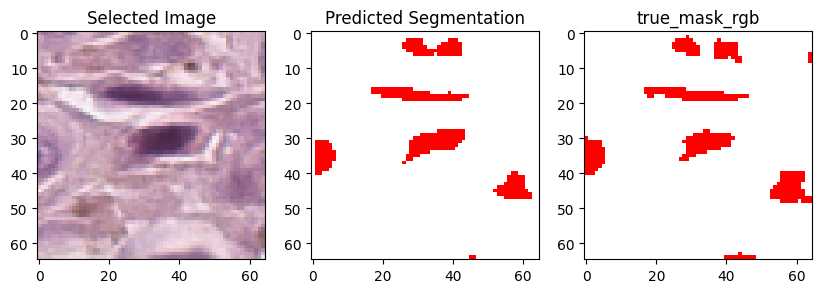

In [10]:
# =======================================================================================
# Loading model and Evaluate model on one random test image from the X_test and then predict 
# =======================================================================================

# Call label_to_rgb function for convert label to original RGB colored masks
%run label_to_rgb.ipynb

# Select test image for prediction and show it
selected_image_index = np.random.randint(len(X_test))
selected_image = X_test[selected_image_index]
preprocessed_image = cv2.resize(selected_image, (65, 65))
preprocessed_image = np.expand_dims(preprocessed_image, axis=0)

# Load the model and use it to predict the segmentation of the selected image
model = load_model(r'/home/user/Desktop/MandalPaperCodePython/SavedFiles/send9.h5', compile=False)
predicted_segmentation = model.predict(preprocessed_image)

# Convert the predicted segmentation to a 2D label array
pred_mask = np.argmax(predicted_segmentation[0], axis=-1)
prediction_to_rgb= label_to_rgb(pred_mask)

# Select ground truth mask for comarision and convert it to a 2D label array and show it
true_mask = np.argmax(y_test[selected_image_index], axis=-1)
true_mask_rgb = label_to_rgb(true_mask)

# Plot the original image and predicted segmentation side by side
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(selected_image)
axs[0].set_title("Selected Image")
axs[1].imshow(prediction_to_rgb)
axs[1].set_title("Predicted Segmentation")
axs[2].imshow(true_mask_rgb)
axs[2].set_title("true_mask_rgb")
plt.savefig("/home/user/Desktop/MandalPaperCodePython/Results/ExImPreMaskGTMask.jpg",dpi=300)
plt.show()

larg image height is= 6711
larg image width is= 5894
larg image channels is= 3
patch size is= 65
Number of vertical ptaches are= 103
Number of horizental ptaches are= 90


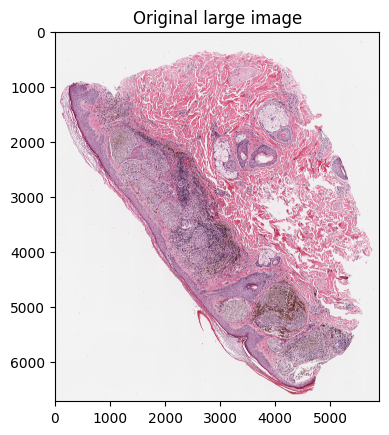

Until now just one empty array is produced to save predicted patches, its name is: "predicted_patches"


In [11]:
# =====================================================================================================
# Load the large image, Calculating number of patches and making empty array to hold predicted patch
# =====================================================================================================

image_path=r"/home/user/Desktop/MandalPaperCodePython/Data/SkinH3.tif"
large_image = cv2.imread(image_path)

# Get the dimensions of the large image
height, width, channels = large_image.shape
print('larg image height is=', height)
print('larg image width is=', width)
print('larg image channels is=', channels)

# Define the patch size
patch_size = 65
print('patch size is=', patch_size)


# Calculate the number of patches in each dimension
num_patches_h = height // patch_size
num_patches_w = width // patch_size
print('Number of vertical ptaches are=', num_patches_h)
print('Number of horizental ptaches are=', num_patches_w)

# =============================================================================
# Initialize an empty array to hold the predicted patches

predicted_patches = np.zeros((num_patches_h, num_patches_w, patch_size, patch_size, channels))
large_image = cv2.cvtColor(large_image, cv2.COLOR_BGR2RGB)
plt.imshow(large_image)
plt.title('Original large image')
plt.savefig(r'/home/user/Desktop/MandalPaperCodePython/Results/MainImage.jpg',dpi=300)
plt.show()
print ('Until now just one empty array is produced to save predicted patches, its name is: "predicted_patches"')

In [12]:
# =====================================================================================================
# Producing predicted patches (by loaded model) and saving them in predicted_patches array  
# =====================================================================================================

print ('In this cell prdicted patches will save in "preprocessed_patch" array')

for i in tqdm(range(num_patches_h)):
    for j in range(num_patches_w):
        # Extract the patch from the large image
        patch = large_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :]
        
        # Preprocess the patch for prediction
        preprocessed_patch = cv2.resize(patch, (65, 65))
        preprocessed_patch = np.expand_dims(preprocessed_patch, axis=0)
        
        # Use the loaded model to predict the segmentation of the patch
        predicted_segmentation = model.predict(preprocessed_patch)
        
        # Convert the predicted segmentation to a 2D label array
        pred_mask = np.argmax(predicted_segmentation[0], axis=-1)
        prediction_to_rgb= label_to_rgb(pred_mask)
#         prediction_to_rgb[0:1,:,0]=prediction_to_rgb[1:2,:,0]
#         prediction_to_rgb[0:1,:,1]=prediction_to_rgb[1:2,:,1]
#         prediction_to_rgb[0:1,:,2]=prediction_to_rgb[1:2,:,2]
#         prediction_to_rgb[:,0:1,0]=prediction_to_rgb[:,1:2,0]
#         prediction_to_rgb[:,0:1,1]=prediction_to_rgb[:,1:2,1]
#         prediction_to_rgb[:,0:1,2]=prediction_to_rgb[:,1:2,2]
       # Store the predicted patch in the array
        predicted_patches[i, j, :, :, :] = prediction_to_rgb
    print('Now your iteration in equal=',i)

print ('Prdicted patches was saved in "preprocessed_patch" array')

In this cell prdicted patches will save in "preprocessed_patch" array


  0%|                                                   | 0/103 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▍                                          | 1/103 [00:05<09:51,  5.80s/it]

Now your iteration in equal= 0
1/1 [==============================] - 0s 13ms/step


  2%|▊                                          | 2/103 [00:11<09:42,  5.76s/it]

Now your iteration in equal= 1
1/1 [==============================] - 0s 13ms/step


  3%|█▎                                         | 3/103 [00:17<09:45,  5.85s/it]

Now your iteration in equal= 2
1/1 [==============================] - 0s 13ms/step


  4%|█▋                                         | 4/103 [00:23<09:34,  5.81s/it]

Now your iteration in equal= 3
1/1 [==============================] - 0s 14ms/step


  5%|██                                         | 5/103 [00:28<09:26,  5.78s/it]

Now your iteration in equal= 4
1/1 [==============================] - 0s 14ms/step


  6%|██▌                                        | 6/103 [00:34<09:19,  5.77s/it]

Now your iteration in equal= 5
1/1 [==============================] - 0s 14ms/step


  7%|██▉                                        | 7/103 [00:40<09:13,  5.76s/it]

Now your iteration in equal= 6
1/1 [==============================] - 0s 14ms/step


  8%|███▎                                       | 8/103 [00:46<09:06,  5.76s/it]

Now your iteration in equal= 7
1/1 [==============================] - 0s 14ms/step


  9%|███▊                                       | 9/103 [00:51<09:01,  5.76s/it]

Now your iteration in equal= 8
1/1 [==============================] - 0s 14ms/step


 10%|████                                      | 10/103 [00:57<08:56,  5.77s/it]

Now your iteration in equal= 9
1/1 [==============================] - 0s 14ms/step


 11%|████▍                                     | 11/103 [01:03<08:50,  5.77s/it]

Now your iteration in equal= 10
1/1 [==============================] - 0s 14ms/step


 12%|████▉                                     | 12/103 [01:09<08:44,  5.77s/it]

Now your iteration in equal= 11
1/1 [==============================] - 0s 16ms/step


 13%|█████▎                                    | 13/103 [01:15<08:44,  5.82s/it]

Now your iteration in equal= 12
1/1 [==============================] - 0s 14ms/step


 14%|█████▋                                    | 14/103 [01:21<08:46,  5.91s/it]

Now your iteration in equal= 13
1/1 [==============================] - 0s 13ms/step


 15%|██████                                    | 15/103 [01:27<08:36,  5.87s/it]

Now your iteration in equal= 14
1/1 [==============================] - 0s 14ms/step


 16%|██████▌                                   | 16/103 [01:32<08:27,  5.83s/it]

Now your iteration in equal= 15
1/1 [==============================] - 0s 14ms/step


 17%|██████▉                                   | 17/103 [01:38<08:19,  5.81s/it]

Now your iteration in equal= 16
1/1 [==============================] - 0s 14ms/step


 17%|███████▎                                  | 18/103 [01:44<08:12,  5.79s/it]

Now your iteration in equal= 17
1/1 [==============================] - 0s 14ms/step


 18%|███████▋                                  | 19/103 [01:50<08:05,  5.78s/it]

Now your iteration in equal= 18
1/1 [==============================] - 0s 14ms/step


 19%|████████▏                                 | 20/103 [01:55<07:59,  5.77s/it]

Now your iteration in equal= 19
1/1 [==============================] - 0s 14ms/step


 20%|████████▌                                 | 21/103 [02:01<07:52,  5.77s/it]

Now your iteration in equal= 20
1/1 [==============================] - 0s 14ms/step


 21%|████████▉                                 | 22/103 [02:07<07:46,  5.77s/it]

Now your iteration in equal= 21
1/1 [==============================] - 0s 13ms/step


 22%|█████████▍                                | 23/103 [02:13<07:41,  5.76s/it]

Now your iteration in equal= 22
1/1 [==============================] - 0s 16ms/step


 23%|█████████▊                                | 24/103 [02:19<07:46,  5.90s/it]

Now your iteration in equal= 23
1/1 [==============================] - 0s 14ms/step


 24%|██████████▏                               | 25/103 [02:25<07:40,  5.90s/it]

Now your iteration in equal= 24
1/1 [==============================] - 0s 13ms/step


 25%|██████████▌                               | 26/103 [02:31<07:31,  5.86s/it]

Now your iteration in equal= 25
1/1 [==============================] - 0s 14ms/step


 26%|███████████                               | 27/103 [02:36<07:23,  5.84s/it]

Now your iteration in equal= 26
1/1 [==============================] - 0s 14ms/step


 27%|███████████▍                              | 28/103 [02:42<07:16,  5.82s/it]

Now your iteration in equal= 27
1/1 [==============================] - 0s 13ms/step


 28%|███████████▊                              | 29/103 [02:48<07:09,  5.81s/it]

Now your iteration in equal= 28
1/1 [==============================] - 0s 14ms/step


 29%|████████████▏                             | 30/103 [02:54<07:03,  5.80s/it]

Now your iteration in equal= 29
1/1 [==============================] - 0s 14ms/step


 30%|████████████▋                             | 31/103 [02:59<06:57,  5.80s/it]

Now your iteration in equal= 30
1/1 [==============================] - 0s 14ms/step


 31%|█████████████                             | 32/103 [03:05<06:51,  5.79s/it]

Now your iteration in equal= 31
1/1 [==============================] - 0s 16ms/step


 32%|█████████████▍                            | 33/103 [03:11<06:49,  5.85s/it]

Now your iteration in equal= 32
1/1 [==============================] - 0s 14ms/step


 33%|█████████████▊                            | 34/103 [03:17<06:44,  5.86s/it]

Now your iteration in equal= 33
1/1 [==============================] - 0s 13ms/step


 34%|██████████████▎                           | 35/103 [03:23<06:36,  5.83s/it]

Now your iteration in equal= 34
1/1 [==============================] - 0s 14ms/step


 35%|██████████████▋                           | 36/103 [03:29<06:28,  5.80s/it]

Now your iteration in equal= 35
1/1 [==============================] - 0s 14ms/step


 36%|███████████████                           | 37/103 [03:34<06:21,  5.79s/it]

Now your iteration in equal= 36
1/1 [==============================] - 0s 14ms/step


 37%|███████████████▍                          | 38/103 [03:40<06:15,  5.78s/it]

Now your iteration in equal= 37
1/1 [==============================] - 0s 14ms/step


 38%|███████████████▉                          | 39/103 [03:46<06:09,  5.77s/it]

Now your iteration in equal= 38
1/1 [==============================] - 0s 14ms/step


 39%|████████████████▎                         | 40/103 [03:52<06:03,  5.77s/it]

Now your iteration in equal= 39
1/1 [==============================] - 0s 14ms/step


 40%|████████████████▋                         | 41/103 [03:57<05:57,  5.77s/it]

Now your iteration in equal= 40
1/1 [==============================] - 0s 13ms/step


 41%|█████████████████▏                        | 42/103 [04:03<05:51,  5.76s/it]

Now your iteration in equal= 41
1/1 [==============================] - 0s 13ms/step


 42%|█████████████████▌                        | 43/103 [04:09<05:45,  5.76s/it]

Now your iteration in equal= 42
1/1 [==============================] - 0s 16ms/step


 43%|█████████████████▉                        | 44/103 [04:15<05:45,  5.86s/it]

Now your iteration in equal= 43
1/1 [==============================] - 0s 14ms/step


 44%|██████████████████▎                       | 45/103 [04:21<05:41,  5.89s/it]

Now your iteration in equal= 44
1/1 [==============================] - 0s 14ms/step


 45%|██████████████████▊                       | 46/103 [04:27<05:33,  5.84s/it]

Now your iteration in equal= 45
1/1 [==============================] - 0s 13ms/step


 46%|███████████████████▏                      | 47/103 [04:32<05:25,  5.81s/it]

Now your iteration in equal= 46
1/1 [==============================] - 0s 14ms/step


 47%|███████████████████▌                      | 48/103 [04:38<05:18,  5.79s/it]

Now your iteration in equal= 47
1/1 [==============================] - 0s 13ms/step


 48%|███████████████████▉                      | 49/103 [04:44<05:11,  5.78s/it]

Now your iteration in equal= 48
1/1 [==============================] - 0s 14ms/step


 49%|████████████████████▍                     | 50/103 [04:50<05:05,  5.77s/it]

Now your iteration in equal= 49
1/1 [==============================] - 0s 14ms/step


 50%|████████████████████▊                     | 51/103 [04:55<04:59,  5.76s/it]

Now your iteration in equal= 50
1/1 [==============================] - 0s 14ms/step


 50%|█████████████████████▏                    | 52/103 [05:01<04:53,  5.75s/it]

Now your iteration in equal= 51
1/1 [==============================] - 0s 14ms/step


 51%|█████████████████████▌                    | 53/103 [05:07<04:47,  5.75s/it]

Now your iteration in equal= 52
1/1 [==============================] - 0s 16ms/step


 52%|██████████████████████                    | 54/103 [05:13<04:45,  5.82s/it]

Now your iteration in equal= 53
1/1 [==============================] - 0s 14ms/step


 53%|██████████████████████▍                   | 55/103 [05:19<04:43,  5.90s/it]

Now your iteration in equal= 54
1/1 [==============================] - 0s 14ms/step


 54%|██████████████████████▊                   | 56/103 [05:25<04:35,  5.85s/it]

Now your iteration in equal= 55
1/1 [==============================] - 0s 14ms/step


 55%|███████████████████████▏                  | 57/103 [05:30<04:27,  5.82s/it]

Now your iteration in equal= 56
1/1 [==============================] - 0s 14ms/step


 56%|███████████████████████▋                  | 58/103 [05:36<04:20,  5.80s/it]

Now your iteration in equal= 57
1/1 [==============================] - 0s 14ms/step


 57%|████████████████████████                  | 59/103 [05:42<04:14,  5.79s/it]

Now your iteration in equal= 58
1/1 [==============================] - 0s 13ms/step


 58%|████████████████████████▍                 | 60/103 [05:48<04:08,  5.78s/it]

Now your iteration in equal= 59
1/1 [==============================] - 0s 14ms/step


 59%|████████████████████████▊                 | 61/103 [05:53<04:02,  5.77s/it]

Now your iteration in equal= 60
1/1 [==============================] - 0s 14ms/step


 60%|█████████████████████████▎                | 62/103 [05:59<03:56,  5.77s/it]

Now your iteration in equal= 61
1/1 [==============================] - 0s 14ms/step


 61%|█████████████████████████▋                | 63/103 [06:05<03:50,  5.77s/it]

Now your iteration in equal= 62
1/1 [==============================] - 0s 14ms/step


 62%|██████████████████████████                | 64/103 [06:11<03:48,  5.86s/it]

Now your iteration in equal= 63
1/1 [==============================] - 0s 13ms/step


 63%|██████████████████████████▌               | 65/103 [06:17<03:41,  5.83s/it]

Now your iteration in equal= 64
1/1 [==============================] - 0s 14ms/step


 64%|██████████████████████████▉               | 66/103 [06:23<03:34,  5.80s/it]

Now your iteration in equal= 65
1/1 [==============================] - 0s 14ms/step


 65%|███████████████████████████▎              | 67/103 [06:28<03:27,  5.78s/it]

Now your iteration in equal= 66
1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████▋              | 68/103 [06:34<03:21,  5.76s/it]

Now your iteration in equal= 67
1/1 [==============================] - 0s 14ms/step


 67%|████████████████████████████▏             | 69/103 [06:40<03:15,  5.76s/it]

Now your iteration in equal= 68
1/1 [==============================] - 0s 14ms/step


 68%|████████████████████████████▌             | 70/103 [06:46<03:09,  5.75s/it]

Now your iteration in equal= 69
1/1 [==============================] - 0s 13ms/step


 69%|████████████████████████████▉             | 71/103 [06:51<03:04,  5.75s/it]

Now your iteration in equal= 70
1/1 [==============================] - 0s 13ms/step


 70%|█████████████████████████████▎            | 72/103 [06:57<02:58,  5.75s/it]

Now your iteration in equal= 71
1/1 [==============================] - 0s 14ms/step


 71%|█████████████████████████████▊            | 73/103 [07:03<02:52,  5.75s/it]

Now your iteration in equal= 72
1/1 [==============================] - 0s 16ms/step


 72%|██████████████████████████████▏           | 74/103 [07:09<02:48,  5.79s/it]

Now your iteration in equal= 73
1/1 [==============================] - 0s 15ms/step


 73%|██████████████████████████████▌           | 75/103 [07:15<02:44,  5.88s/it]

Now your iteration in equal= 74
1/1 [==============================] - 0s 14ms/step


 74%|██████████████████████████████▉           | 76/103 [07:21<02:37,  5.85s/it]

Now your iteration in equal= 75
1/1 [==============================] - 0s 14ms/step


 75%|███████████████████████████████▍          | 77/103 [07:26<02:31,  5.81s/it]

Now your iteration in equal= 76
1/1 [==============================] - 0s 14ms/step


 76%|███████████████████████████████▊          | 78/103 [07:32<02:24,  5.78s/it]

Now your iteration in equal= 77
1/1 [==============================] - 0s 15ms/step


 77%|████████████████████████████████▏         | 79/103 [07:38<02:18,  5.76s/it]

Now your iteration in equal= 78
1/1 [==============================] - 0s 14ms/step


 78%|████████████████████████████████▌         | 80/103 [07:43<02:12,  5.75s/it]

Now your iteration in equal= 79
1/1 [==============================] - 0s 14ms/step


 79%|█████████████████████████████████         | 81/103 [07:49<02:06,  5.74s/it]

Now your iteration in equal= 80
1/1 [==============================] - 0s 14ms/step


 80%|█████████████████████████████████▍        | 82/103 [07:55<02:00,  5.73s/it]

Now your iteration in equal= 81
1/1 [==============================] - 0s 14ms/step


 81%|█████████████████████████████████▊        | 83/103 [08:01<01:54,  5.72s/it]

Now your iteration in equal= 82
1/1 [==============================] - 0s 13ms/step


 82%|██████████████████████████████████▎       | 84/103 [08:06<01:48,  5.72s/it]

Now your iteration in equal= 83
1/1 [==============================] - 0s 17ms/step


 83%|██████████████████████████████████▋       | 85/103 [08:12<01:45,  5.84s/it]

Now your iteration in equal= 84
1/1 [==============================] - 0s 14ms/step


 83%|███████████████████████████████████       | 86/103 [08:18<01:39,  5.85s/it]

Now your iteration in equal= 85
1/1 [==============================] - 0s 14ms/step


 84%|███████████████████████████████████▍      | 87/103 [08:24<01:32,  5.81s/it]

Now your iteration in equal= 86
1/1 [==============================] - 0s 14ms/step


 85%|███████████████████████████████████▉      | 88/103 [08:30<01:26,  5.79s/it]

Now your iteration in equal= 87
1/1 [==============================] - 0s 14ms/step


 86%|████████████████████████████████████▎     | 89/103 [08:35<01:20,  5.77s/it]

Now your iteration in equal= 88
1/1 [==============================] - 0s 14ms/step


 87%|████████████████████████████████████▋     | 90/103 [08:41<01:14,  5.76s/it]

Now your iteration in equal= 89
1/1 [==============================] - 0s 15ms/step


 88%|█████████████████████████████████████     | 91/103 [08:47<01:09,  5.76s/it]

Now your iteration in equal= 90
1/1 [==============================] - 0s 14ms/step


 89%|█████████████████████████████████████▌    | 92/103 [08:53<01:03,  5.76s/it]

Now your iteration in equal= 91
1/1 [==============================] - 0s 14ms/step


 90%|█████████████████████████████████████▉    | 93/103 [08:58<00:57,  5.75s/it]

Now your iteration in equal= 92
1/1 [==============================] - 0s 17ms/step


 91%|██████████████████████████████████████▎   | 94/103 [09:04<00:52,  5.81s/it]

Now your iteration in equal= 93
1/1 [==============================] - 0s 15ms/step


 92%|██████████████████████████████████████▋   | 95/103 [09:10<00:46,  5.83s/it]

Now your iteration in equal= 94
1/1 [==============================] - 0s 14ms/step


 93%|███████████████████████████████████████▏  | 96/103 [09:16<00:40,  5.80s/it]

Now your iteration in equal= 95
1/1 [==============================] - 0s 14ms/step


 94%|███████████████████████████████████████▌  | 97/103 [09:22<00:34,  5.78s/it]

Now your iteration in equal= 96
1/1 [==============================] - 0s 14ms/step


 95%|███████████████████████████████████████▉  | 98/103 [09:27<00:28,  5.77s/it]

Now your iteration in equal= 97
1/1 [==============================] - 0s 14ms/step


 96%|████████████████████████████████████████▎ | 99/103 [09:33<00:23,  5.77s/it]

Now your iteration in equal= 98
1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████▊ | 100/103 [09:39<00:17,  5.76s/it]

Now your iteration in equal= 99
1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████▏| 101/103 [09:45<00:11,  5.76s/it]

Now your iteration in equal= 100
1/1 [==============================] - 0s 14ms/step


 99%|████████████████████████████████████████▌| 102/103 [09:50<00:05,  5.76s/it]

Now your iteration in equal= 101
1/1 [==============================] - 0s 15ms/step


100%|█████████████████████████████████████████| 103/103 [09:56<00:00,  5.79s/it]

Now your iteration in equal= 102
Prdicted patches was saved in "preprocessed_patch" array


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


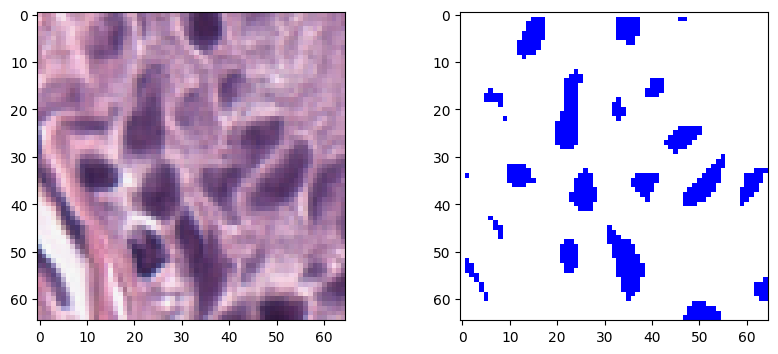

In [15]:
# =====================================================================================================
# Test the model on one patch of big image, Select a random patch from the big image and then predict 
# =====================================================================================================

aa=np.random.randint(num_patches_h)
bb=np.random.randint(num_patches_w)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.imshow(np.reshape(large_image[aa*patch_size:(aa+1)*patch_size, bb*patch_size:(bb+1)*patch_size, :], (65, 65, 3)))
plt.subplot(122)
plt.imshow(np.reshape(predicted_patches[aa,bb,:,:,:], (65, 65,3)))
plt.savefig(r'/home/user/Desktop/MandalPaperCodePython/Results/Im&MaskfromBigIm.jpg',dpi=300)
plt.show()

In [16]:
# =============================================================================
# Reshape the predicted patches array into a single image as a predicted image
# =============================================================================

predicted_image = np.zeros((height, width, channels))
for i in range(num_patches_h):
    for j in range(num_patches_w):
        predicted_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :] = predicted_patches[i, j, :, :, :]

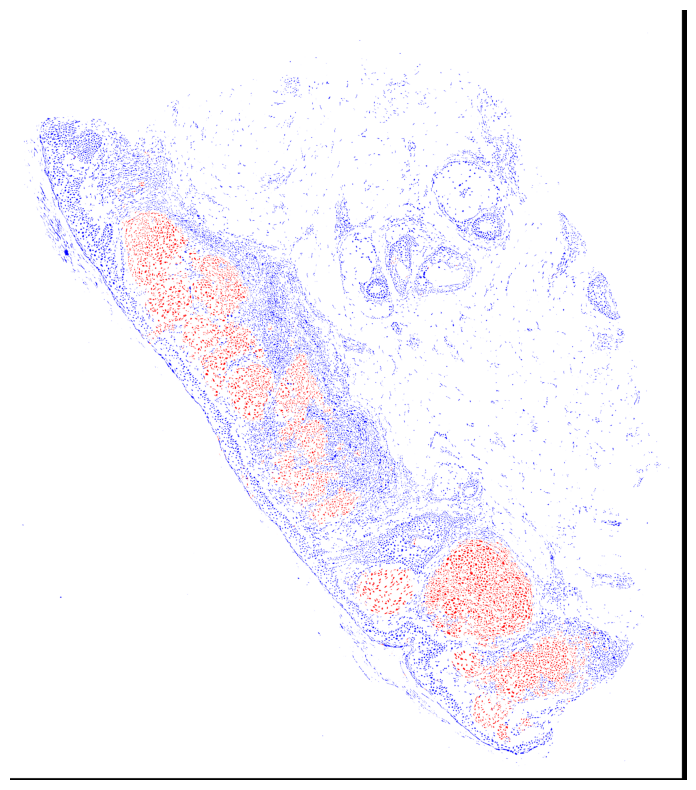

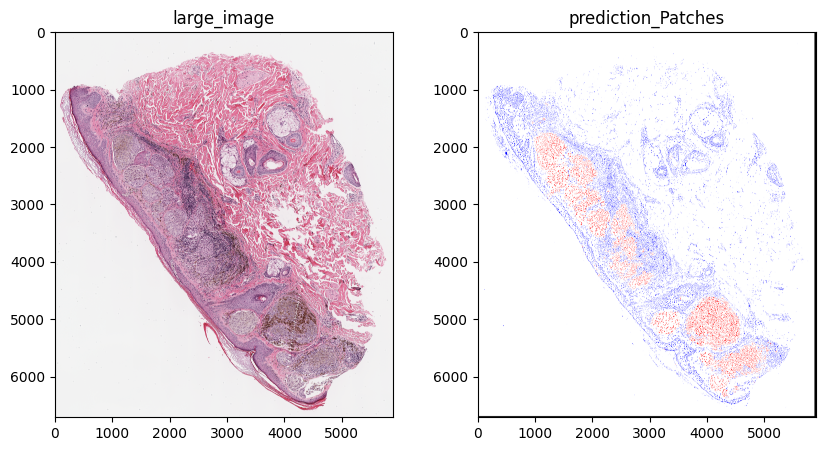

In [17]:
# ======================================================================================
# Showing: First: predicted big image, Second: Main Image and Predicted Image together 
# ======================================================================================

# Convert the image to a supported depth
predicted_image_astype = predicted_image.astype('uint8')
predicted_image_astype1=predicted_image_astype
cv2.imwrite("/home/user/Desktop/MandalPaperCodePython/Results/MigImMaskForMor.jpg",predicted_image_astype)
# Plot the predicted big image
fig, ax = plt.subplots(figsize=(10, 10))
# Display the predicted image
# ax.imshow(cv2.cvtColor(predicted_image_astype, cv2.COLOR_BGR2RGB))
ax.imshow (predicted_image_astype)
# Turn off the axis labels
ax.axis('off')
# Show the plot
plt.savefig("/home/user/Desktop/MandalPaperCodePython/Results/LargImPredicted.jpg",dpi=300)
plt.show()

# Plot the original image alongside the predicted big image
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(large_image)
axs[0].set_title('large_image')
# axs[1].imshow(cv2.cvtColor(predicted_image_astype, cv2.COLOR_BGR2RGB))
axs[1].imshow(predicted_image_astype)
axs[1].set_title('prediction_Patches')
plt.savefig("/home/user/Desktop/MandalPaperCodePython/Results/MainLaImAndPreIm.jpg",dpi=300)
plt.show()

In [18]:
# =====================================================================================================
# Melanoma Classification metrics on big image-Without empty first row and column
# =====================================================================================================

mask_path = r"/home/user/Desktop/MandalPaperCodePython/Data/BigImGT.png"
MaskGrTr = cv2.imread(mask_path)
MaskGrTr=cv2.cvtColor(MaskGrTr, cv2.COLOR_BGR2RGB)

TP=TN=FP=FN=0

for i in tqdm(range(num_patches_h)):
    for j in range(num_patches_w):
        predicted_patch=predicted_patches[i, j, :, :, :]
        
        bb=predicted_patch[:,:,1]
        bb2 = np.where(bb < 200, 1, 0)
        bbb=predicted_patch[:,:,2]
        bbb2 = np.where(bbb < 200, 1, 0)
        binary_maskP=np.logical_and(bb2, bbb2)
        binary_maskP = binary_maskP.astype(np.int)
        binary_maskPnot = np.logical_not(binary_maskP).astype(np.int)
        
        MaskGT = MaskGrTr[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :]
        aa=MaskGT [:,:,1]
        aa2 = np.where(aa < 200, 1, 0)
        aaa=MaskGT [:,:,2]
        aaa2 = np.where(aaa < 200, 1, 0)
        binary_maskG=np.logical_and(aa2, aaa2)
        binary_maskG = binary_maskG.astype(np.int)
        binary_maskGnot = np.logical_not(binary_maskG).astype(np.int)
        
        TP = TP+np.sum(np.logical_and(binary_maskP[1:64,1:64], binary_maskG[1:64,1:64]))
        TN = TN+np.sum(np.logical_and(binary_maskPnot[1:64,1:64], binary_maskGnot[1:64,1:64]))
        FP = FP+np.sum(np.logical_and(binary_maskP[1:64,1:64], binary_maskGnot[1:64,1:64]))
        FN = FN+np.sum(np.logical_and(binary_maskPnot[1:64,1:64], binary_maskG[1:64,1:64]))

print('TP=',TP)    
print('TN=',TN) 
print('FP=',FP)
print('FN=',FN)

accuracy = ((TP + TN) / (TN + FP + FN + TP)) * 100
print('accuracy=',accuracy)
precision = (TP / (TP + FP)) * 100
print('precision=',precision) 
sensitivity = (TP / (TP + FN)) * 100
print('Recall(sesitivity)=',sensitivity)    
DiceCoefficient = (TP / (FP + TP + TP + FN)) * 200
print('Dice Coefficient(Fscore)=',DiceCoefficient)
JaccardScore = (TP / (FP + TP + FN)) * 100
print('Jaccard Score=',JaccardScore)

  0%|                                                   | 0/103 [00:00<?, ?it/s]/tmp/ipykernel_3267/812940292.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  binary_maskP = binary_maskP.astype(np.int)
/tmp/ipykernel_3267/812940292.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current 

TP= 294196
TN= 36338305
FP= 57981
FN= 102148
accuracy= 99.5647796854968
precision= 83.53640356979587
Recall(sesitivity)= 74.22743879054559
Dice Coefficient(Fscore)= 78.60728022326695
Jaccard Score= 64.75452594508336


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


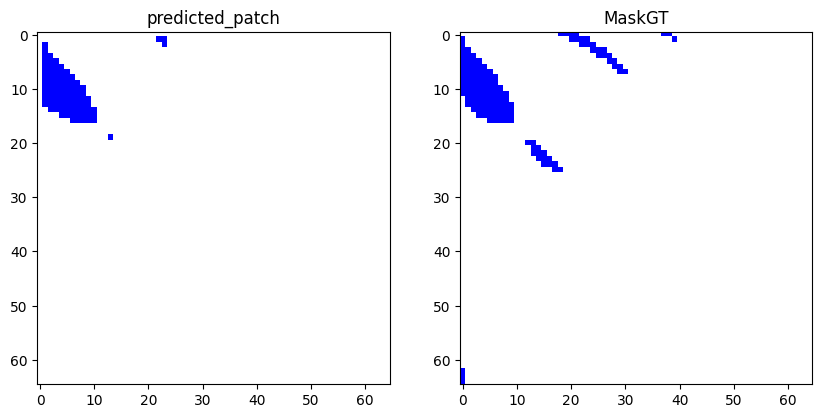

In [19]:
i=60
j=60
predicted_patch=predicted_patches[i, j, :, :, :]
MaskGT = MaskGrTr[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(predicted_patch)
axs[0].set_title('predicted_patch')
axs[1].imshow(MaskGT)
axs[1].set_title('MaskGT')
plt.show()

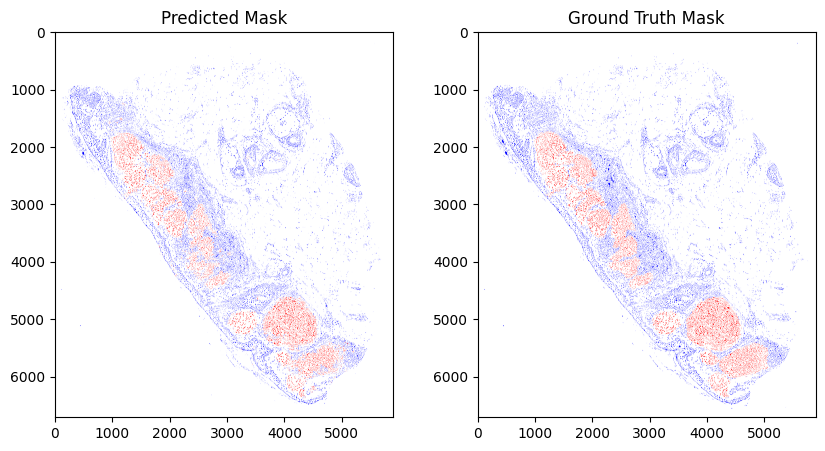

/tmp/ipykernel_3267/3417688437.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  binary_maskP = binary_maskP.astype(np.int)
/tmp/ipykernel_3267/3417688437.py:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in Num

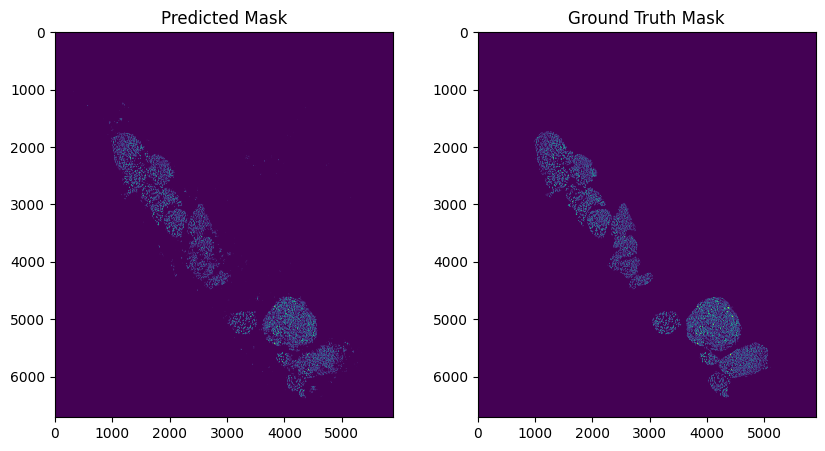

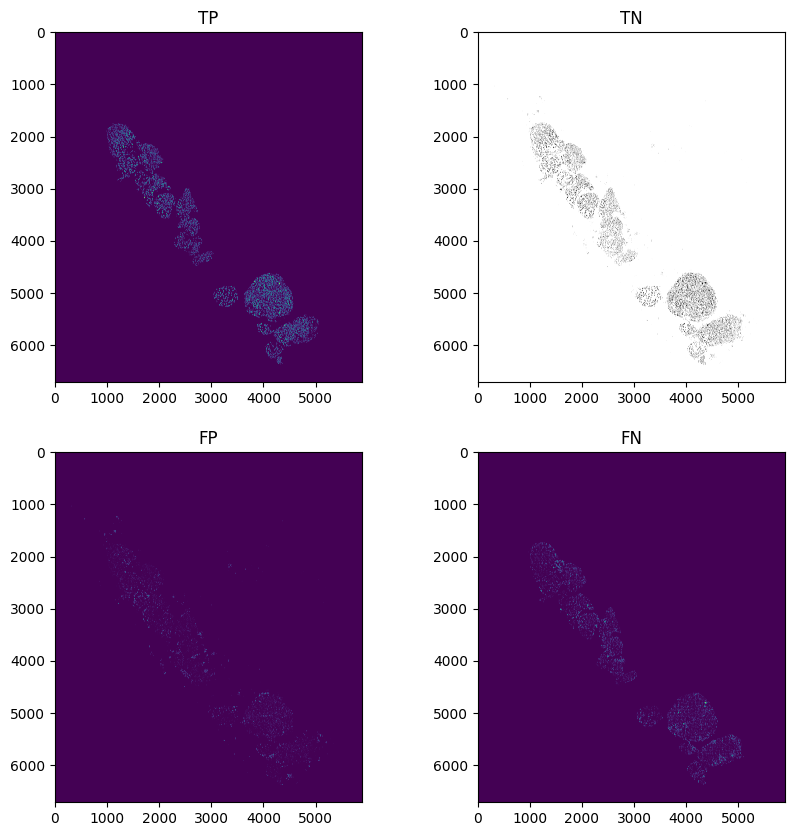

TP= 302214
TN= 39072272
FP= 60482
FN= 119666
accuracy= 99.54455905217073
precision= 83.32432670886914
Recall(sesitivity)= 71.63506210296767
Dice Coefficient(Fscore)= 77.03880822253039
Jaccard Score= 62.6529452983444


In [20]:
# =====================================================================================================
# Melanoma Classification metrics on big image-With empty first row and column
# =====================================================================================================
MaskPre=predicted_image_astype1

#Predicted Mask edge elinmination
MaskPre[6500:6711,:,:]=255
MaskPre[:,5700:5894,:]=255

mask_path = r"/home/user/Desktop/MandalPaperCodePython/Data/BigImGT.png"
MaskGT = cv2.imread(mask_path)
MaskGT=cv2.cvtColor(MaskGT, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(MaskPre)
axs[0].set_title('Predicted Mask')
axs[1].imshow(MaskGT)
axs[1].set_title('Ground Truth Mask')
plt.savefig("/home/user/Desktop/MandalPaperCodePython/Results/BigImPre&GT.jpg",dpi=300)
plt.show()

bb=MaskPre[:,:,1]
bb2 = np.where(bb < 200, 1, 0)
bbb=MaskPre[:,:,2]
bbb2 = np.where(bbb < 200, 1, 0)
binary_maskP=np.logical_and(bb2, bbb2)
binary_maskP = binary_maskP.astype(np.int)
binary_maskPnot = np.logical_not(binary_maskP).astype(np.int)

aa=MaskGT [:,:,1]
aa2 = np.where(aa < 200, 1, 0)
aaa=MaskGT [:,:,2]
aaa2 = np.where(aaa < 200, 1, 0)
binary_maskG=np.logical_and(aa2, aaa2)
binary_maskG = binary_maskG.astype(np.int)
binary_maskGnot = np.logical_not(binary_maskG).astype(np.int)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(binary_maskP)
axs[0].set_title('Predicted Mask')
axs[1].imshow(binary_maskG)
axs[1].set_title('Ground Truth Mask')
plt.savefig("/home/user/Desktop/MandalPaperCodePython/Results/BigImMaskPre&GT.jpg",dpi=300)
plt.show()

TP = np.sum(np.logical_and(binary_maskP, binary_maskG))
TN = np.sum(np.logical_and(binary_maskPnot, binary_maskGnot))
FP = np.sum(np.logical_and(binary_maskP, binary_maskGnot))
FN = np.sum(np.logical_and(binary_maskPnot, binary_maskG))

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(np.logical_and(binary_maskP, binary_maskG))
axs[0, 0].set_title('TP')
axs[0, 1].imshow(np.logical_and(binary_maskPnot, binary_maskGnot),cmap='gray')
axs[0, 1].set_title('TN')
axs[1, 0].imshow(np.logical_and(binary_maskP, binary_maskGnot))
axs[1, 0].set_title('FP')
axs[1, 1].imshow(np.logical_and(binary_maskPnot, binary_maskG))
axs[1, 1].set_title('FN')
plt.savefig("/home/user/Desktop/MandalPaperCodePython/Results/BigImMaskTPTNFPFN.jpg",dpi=300)
plt.show()

print('TP=',TP)    
print('TN=',TN) 
print('FP=',FP)
print('FN=',FN)

accuracy = ((TP + TN) / (TN + FP + FN + TP)) * 100
print('accuracy=',accuracy)
precision = (TP / (TP + FP)) * 100
print('precision=',precision) 
sensitivity = (TP / (TP + FN)) * 100
print('Recall(sesitivity)=',sensitivity)    
DiceCoefficient = (TP / (FP + TP + TP + FN)) * 200
print('Dice Coefficient(Fscore)=',DiceCoefficient)
JaccardScore = (TP / (FP + TP + FN)) * 100
print('Jaccard Score=',JaccardScore)

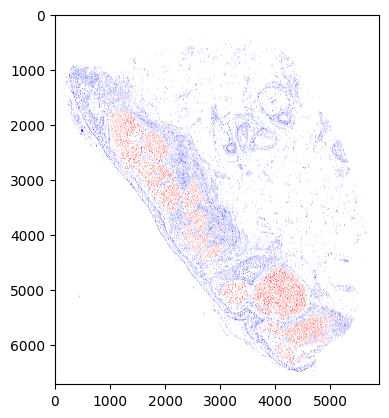

In [22]:
# MaskPre=predicted_image_astype1
plt.imshow(predicted_image_astype1)
plt.show()

/tmp/ipykernel_3267/127149045.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pre_maskM = pre_maskM.astype(np.int)
/tmp/ipykernel_3267/127149045.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

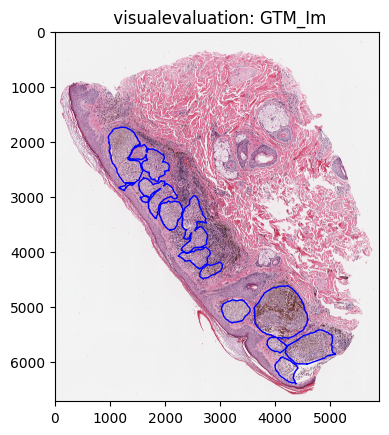

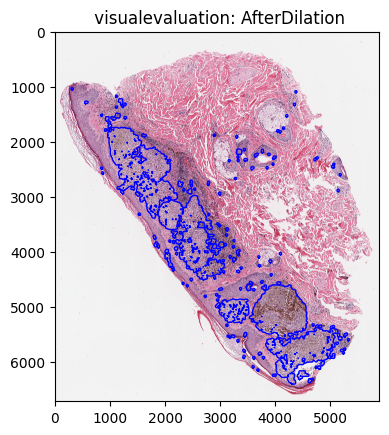

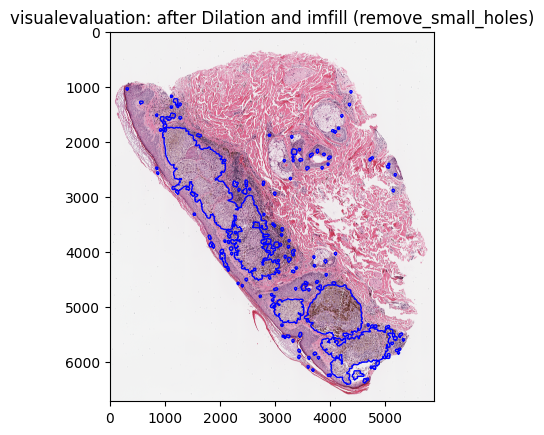

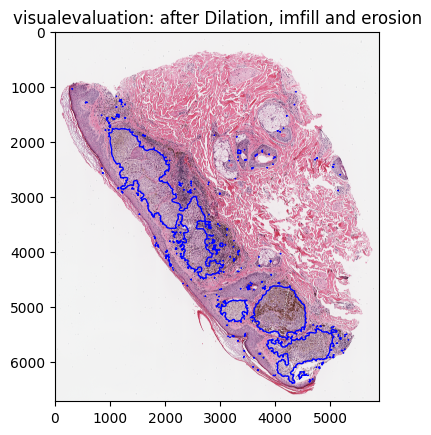

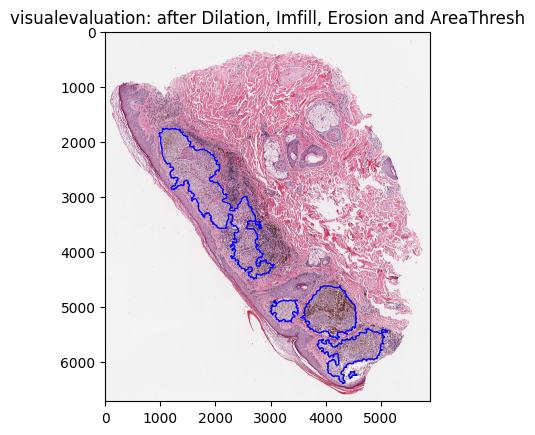

In [73]:
# =====================================================================================================
# Morpholigical Figures
# =====================================================================================================

MaskPre=predicted_image_astype1
MaskPre[6500:6711,:,:]=255
MaskPre[:,5700:5894,:]=255
predicted_image = MaskPre

%run visualevaluation1.ipynb

bb=predicted_image[:,:,1]
bb2 = np.where(bb < 200, 1, 0)
bbb=predicted_image[:,:,2]
bbb2 = np.where(bbb < 200, 1, 0)
pre_maskM=np.logical_and(bb2, bbb2)
pre_maskM = pre_maskM.astype(np.int)
pre_maskMnot = np.logical_not(pre_maskM).astype(np.int)

filepart2 = "/home/user/Desktop/MandalPaperCodePython/Data/"
mask_Binary = scipy.io.loadmat(filepart2 + 'BW1.mat')
GTM = mask_Binary['BW1'] # GTM
GTM = GTM.astype(np.float32)
GTMnot=np.logical_not(GTM).astype(np.int)

# =====================================================================================================
# Before Dilation

plt.figure(1)
plt.title(' visualevaluation: GTM_Im')
save_result ='/home/user/Desktop/MandalPaperCodePython/Results/MelanomaObjectionEvaulation1/1_GTM_Im(Ground Truth).png'
visualevaluation1(GTM, Im, save_result)
# =====================================================================================================
# After Dilation

radius = 20
selem = disk(radius)
pre_maskM = binary_dilation(pre_maskM, structure=selem)

plt.figure(2)
plt.title(' visualevaluation: AfterDilation')
save_result ='/home/user/Desktop/MandalPaperCodePython/Results/MelanomaObjectionEvaulation1/AfterDilation.png'
visualevaluation1(pre_maskM, Im, save_result)

# =====================================================================================================
# After Dilation and Image Fill

pre_maskM = binary_fill_holes(pre_maskM)

plt.figure(3)
plt.title('visualevaluation: after Dilation and imfill (remove_small_holes)')
save_result ='/home/user/Desktop/MandalPaperCodePython/Results/MelanomaObjectionEvaulation1/AfterDilationandImageFil.png'
visualevaluation1(pre_maskM, Im, save_result)

# =====================================================================================================
# After Dilation, Image Fill and Erosion

pre_maskM = binary_erosion(pre_maskM, structure=selem)
pre_maskMback=pre_maskM

plt.figure(4)
plt.title('visualevaluation: after Dilation, imfill and erosion')
save_result ='/home/user/Desktop/MandalPaperCodePython/Results/MelanomaObjectionEvaulation1/AfterDilationImageFilandErosion.png'
visualevaluation1(pre_maskM, Im, save_result)

# =====================================================================================================
# After Dilation, Image Fill, Erosion and AreaThreshold

pre_maskM = remove_small_objects(pre_maskM, min_size=4000, connectivity=8)

plt.figure(5)
plt.title('visualevaluation: after Dilation, Imfill, Erosion and AreaThresh')
save_result ='/home/user/Desktop/MandalPaperCodePython/Results/MelanomaObjectionEvaulation1/AfterDilationImageFilErosionandThr.png'
visualevaluation1(pre_maskM, Im, save_result)

/tmp/ipykernel_3267/1583809383.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pre_maskM = pre_maskM.astype(np.int)
/tmp/ipykernel_3267/1583809383.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.2

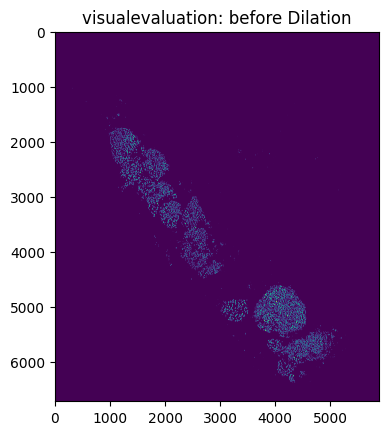

These results are for before dilation
TP(beforeDilation)= 339912
TN(beforeDilation)= 36546592
FP(beforeDilation)= 22784
FN(beforeDilation)= 2645346
accuracy(beforeDilation)= 93.2545703747379
precision(beforeDilation)= 93.71815514921587
Recall(sesitivity)(beforeDilation)= 11.38635253636369
Dice Coefficient(Fscore)(beforeDilation)= 20.3056553345715
Jaccard Score(beforeDilation)= 11.300108176681043


/tmp/ipykernel_3267/1583809383.py:59: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pre_maskMnot = np.logical_not(pre_maskM).astype(np.int)


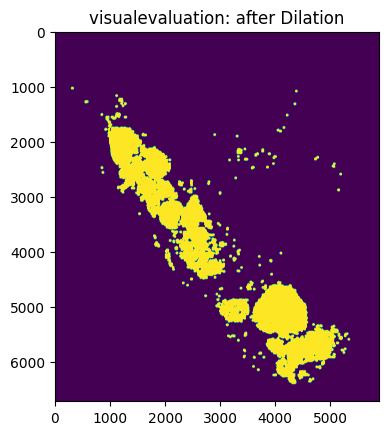

your Dilation factor is= 26
These are results for After Dilation
TP(afterDilation)= 2914587
TN(afterDilation)= 35339372
FP(afterDilation)= 1230004
FN(afterDilation)= 70671
accuracy(afterDilation)= 96.71170007539446
precision(afterDilation)= 70.32266875066804
Recall(sesitivity)(afterDilation)= 97.63266692527078
Dice Coefficient(Fscore)(afterDilation)= 81.75732753947524
Jaccard Score(afterDilation)= 69.14367363167462


/tmp/ipykernel_3267/1583809383.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pre_maskMnot = np.logical_not(pre_maskM).astype(np.int)


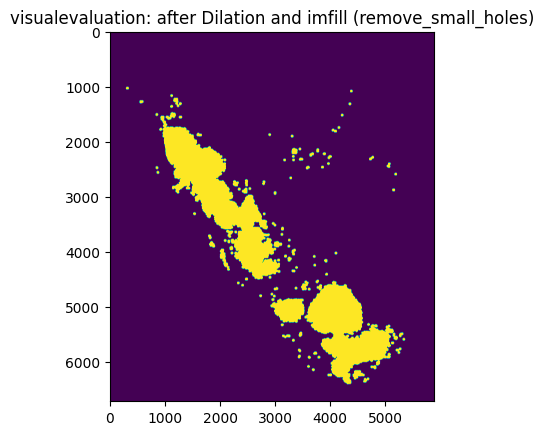

your Dilation factor is= 26
These are results for After Dilation and ImageFill
TP(afterDilation and imfill)= 2935896
TN(afterDilation and imfill)= 35302293
FP(afterDilation and imfill)= 1267083
FN(afterDilation and imfill)= 49362
accuracy(afterDilation and imfill)= 96.67183116901043
precision(afterDilation and imfill)= 69.85274016358397
Recall(sesitivity)(afterDilation and imfill)= 98.34647457606678
Dice Coefficient(Fscore)(afterDilation and imfill)= 81.68612136745074
Jaccard Score(afterDilation and imfill)= 69.04187599254152


/tmp/ipykernel_3267/1583809383.py:128: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pre_maskMnot = np.logical_not(pre_maskM).astype(np.int)


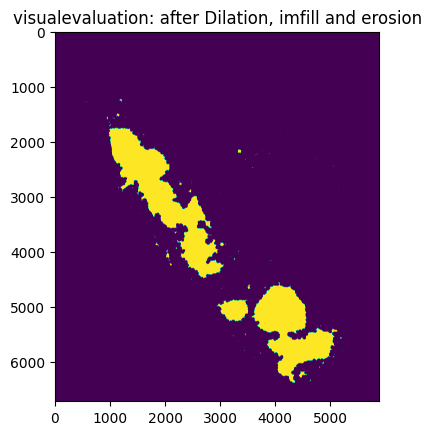

your Dilation factor is= 26
These are results for After Dilation, ImageFill and Erosion
TP(after Dilation, imfill and erosion)= 2718575
TN(after Dilation, imfill and erosion)= 36202518
FP(after Dilation, imfill and erosion)= 366858
FN(after Dilation, imfill and erosion)= 266683
accuracy(after Dilation, imfill and erosion)= 98.39831408881194
precision(after Dilation, imfill and erosion)= 88.10999947171109
Recall(sesitivity)(after Dilation, imfill and erosion)= 91.0666682745679
Dice Coefficient(Fscore)(after Dilation, imfill and erosion)= 89.56393926160959
Jaccard Score(after Dilation, imfill and erosion)= 81.10026621990409


/tmp/ipykernel_3267/1583809383.py:162: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pre_maskMnot = np.logical_not(pre_maskM).astype(np.int)


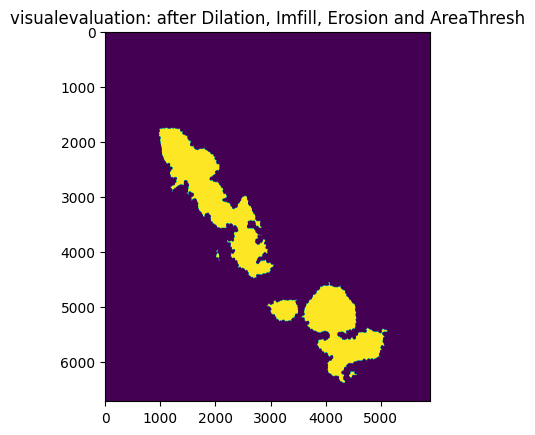

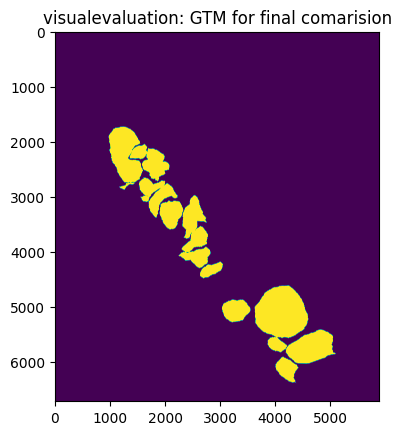

your Dilation factor is= 26
These are results for After Dilation, ImageFill, Erosion and Threshold
TP(after Dilation, Imfill, Erosion and AreaThresh)= 2718564
TN(after Dilation, Imfill, Erosion and AreaThresh)= 36228466
FP(after Dilation, Imfill, Erosion and AreaThresh)= 340910
FN(after Dilation, Imfill, Erosion and AreaThresh)= 266694
accuracy(after Dilation, Imfill, Erosion and AreaThresh)= 98.46388668392179
precision(after Dilation, Imfill, Erosion and AreaThresh)= 88.85723493646293
Recall(sesitivity)(after Dilation, Imfill, Erosion and AreaThresh)= 91.06629979720346
Dice Coefficient(Fscore)(after Dilation, Imfill, Erosion and AreaThresh)= 89.94820614048729
Jaccard Score(after Dilation, Imfill, Erosion and AreaThresh)= 81.73261242366591


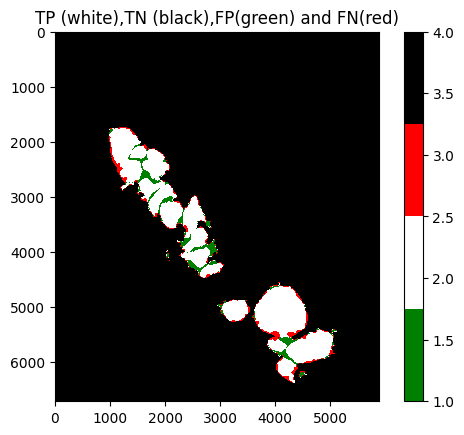

your Dilation factor is= 26


In [81]:
# =====================================================================================================
# Morpholigical metrics
# =====================================================================================================
MaskPre=predicted_image_astype1
MaskPre[6500:6711,:,:]=255
MaskPre[:,5700:5894,:]=255
predicted_image = MaskPre

bb=predicted_image[:,:,1]
bb2 = np.where(bb < 200, 1, 0)
bbb=predicted_image[:,:,2]
bbb2 = np.where(bbb < 200, 1, 0)
pre_maskM=np.logical_and(bb2, bbb2)
pre_maskM = pre_maskM.astype(np.int)
pre_maskMnot = np.logical_not(pre_maskM).astype(np.int)

filepart2 = "/home/user/Desktop/MandalPaperCodePython/Data/"
mask_Binary = scipy.io.loadmat(filepart2 + 'BW1.mat')
GTM = mask_Binary['BW1'] # GTM
GTM = GTM.astype(np.float32)
GTMnot=np.logical_not(GTM).astype(np.int)

# =====================================================================================================
# Before Dilation

plt.figure(1)
plt.title('visualevaluation: before Dilation')
plt.imshow(pre_maskM)
plt.show()

TP = np.sum(np.logical_and(pre_maskM, GTM))
TN = np.sum(np.logical_and(pre_maskMnot, GTMnot))
FP = np.sum(np.logical_and(pre_maskM, GTMnot))
FN = np.sum(np.logical_and(pre_maskMnot, GTM))

print('These results are for before dilation')
print('TP(beforeDilation)=',TP)    
print('TN(beforeDilation)=',TN) 
print('FP(beforeDilation)=',FP)
print('FN(beforeDilation)=',FN)

accuracy = ((TP + TN) / (TN + FP + FN + TP)) * 100
print('accuracy(beforeDilation)=',accuracy)
precision = (TP / (TP + FP)) * 100
print('precision(beforeDilation)=',precision) 
sensitivity = (TP / (TP + FN)) * 100
print('Recall(sesitivity)(beforeDilation)=',sensitivity)    
DiceCoefficient = (TP / (FP + TP + TP + FN)) * 200
print('Dice Coefficient(Fscore)(beforeDilation)=',DiceCoefficient)
JaccardScore = (TP / (FP + TP + FN)) * 100
print('Jaccard Score(beforeDilation)=',JaccardScore)

# =====================================================================================================
# After Dilation

radius = 26
selem = disk(radius)
pre_maskM = binary_dilation(pre_maskM, structure=selem)
pre_maskMnot = np.logical_not(pre_maskM).astype(np.int)

plt.figure(2)
plt.title('visualevaluation: after Dilation')
plt.imshow(pre_maskM)
plt.show()

print('your Dilation factor is=',radius)
print('These are results for After Dilation')
TP = np.sum(np.logical_and(pre_maskM, GTM))
TN = np.sum(np.logical_and(pre_maskMnot, GTMnot))
FP = np.sum(np.logical_and(pre_maskM, GTMnot))
FN = np.sum(np.logical_and(pre_maskMnot, GTM))

print('TP(afterDilation)=',TP)    
print('TN(afterDilation)=',TN) 
print('FP(afterDilation)=',FP)
print('FN(afterDilation)=',FN)

accuracy = ((TP + TN) / (TN + FP + FN + TP)) * 100
print('accuracy(afterDilation)=',accuracy)
precision = (TP / (TP + FP)) * 100
print('precision(afterDilation)=',precision) 
sensitivity = (TP / (TP + FN)) * 100
print('Recall(sesitivity)(afterDilation)=',sensitivity)    
DiceCoefficient = (TP / (FP + TP + TP + FN)) * 200
print('Dice Coefficient(Fscore)(afterDilation)=',DiceCoefficient)
JaccardScore = (TP / (FP + TP + FN)) * 100
print('Jaccard Score(afterDilation)=',JaccardScore)

# =====================================================================================================
# After Dilation and Image Fill

pre_maskM = binary_fill_holes(pre_maskM)
pre_maskMnot = np.logical_not(pre_maskM).astype(np.int)

plt.figure(3)
plt.title('visualevaluation: after Dilation and imfill (remove_small_holes)')
plt.imshow(pre_maskM)
plt.show()

print('your Dilation factor is=',radius)
print('These are results for After Dilation and ImageFill')
TP = np.sum(np.logical_and(pre_maskM, GTM))
TN = np.sum(np.logical_and(pre_maskMnot, GTMnot))
FP = np.sum(np.logical_and(pre_maskM, GTMnot))
FN = np.sum(np.logical_and(pre_maskMnot, GTM))

print('TP(afterDilation and imfill)=',TP)    
print('TN(afterDilation and imfill)=',TN) 
print('FP(afterDilation and imfill)=',FP)
print('FN(afterDilation and imfill)=',FN)

accuracy = ((TP + TN) / (TN + FP + FN + TP)) * 100
print('accuracy(afterDilation and imfill)=',accuracy)
precision = (TP / (TP + FP)) * 100
print('precision(afterDilation and imfill)=',precision) 
sensitivity = (TP / (TP + FN)) * 100
print('Recall(sesitivity)(afterDilation and imfill)=',sensitivity)    
DiceCoefficient = (TP / (FP + TP + TP + FN)) * 200
print('Dice Coefficient(Fscore)(afterDilation and imfill)=',DiceCoefficient)
JaccardScore = (TP / (FP + TP + FN)) * 100
print('Jaccard Score(afterDilation and imfill)=',JaccardScore)

# =====================================================================================================
# After Dilation, Image Fill and Erosion

pre_maskM = binary_erosion(pre_maskM, structure=selem)
pre_maskMback=pre_maskM
pre_maskMnot = np.logical_not(pre_maskM).astype(np.int)

plt.figure(4)
plt.title('visualevaluation: after Dilation, imfill and erosion')
plt.imshow(pre_maskM)
plt.show()

print('your Dilation factor is=',radius)
print('These are results for After Dilation, ImageFill and Erosion')
TP = np.sum(np.logical_and(pre_maskM, GTM))
TN = np.sum(np.logical_and(pre_maskMnot, GTMnot))
FP = np.sum(np.logical_and(pre_maskM, GTMnot))
FN = np.sum(np.logical_and(pre_maskMnot, GTM))

print('TP(after Dilation, imfill and erosion)=',TP)    
print('TN(after Dilation, imfill and erosion)=',TN) 
print('FP(after Dilation, imfill and erosion)=',FP)
print('FN(after Dilation, imfill and erosion)=',FN)

accuracy = ((TP + TN) / (TN + FP + FN + TP)) * 100
print('accuracy(after Dilation, imfill and erosion)=',accuracy)
precision = (TP / (TP + FP)) * 100
print('precision(after Dilation, imfill and erosion)=',precision) 
sensitivity = (TP / (TP + FN)) * 100
print('Recall(sesitivity)(after Dilation, imfill and erosion)=',sensitivity)    
DiceCoefficient = (TP / (FP + TP + TP + FN)) * 200
print('Dice Coefficient(Fscore)(after Dilation, imfill and erosion)=',DiceCoefficient)
JaccardScore = (TP / (FP + TP + FN)) * 100
print('Jaccard Score(after Dilation, imfill and erosion)=',JaccardScore)

# =====================================================================================================
# After Dilation, Image Fill, Erosion and AreaThreshold

pre_maskM = remove_small_objects(pre_maskM, min_size=4000, connectivity=8)
pre_maskMnot = np.logical_not(pre_maskM).astype(np.int)

plt.figure(5)
plt.title('visualevaluation: after Dilation, Imfill, Erosion and AreaThresh')
plt.imshow(pre_maskM)
plt.show()

plt.figure(6)
plt.title('visualevaluation: GTM for final comarision')
plt.imshow(GTM)
plt.show()

print('your Dilation factor is=',radius)
print('These are results for After Dilation, ImageFill, Erosion and Threshold')
TP = np.sum(np.logical_and(pre_maskM, GTM))
TN = np.sum(np.logical_and(pre_maskMnot, GTMnot))
FP = np.sum(np.logical_and(pre_maskM, GTMnot))
FN = np.sum(np.logical_and(pre_maskMnot, GTM))

print('TP(after Dilation, Imfill, Erosion and AreaThresh)=',TP)    
print('TN(after Dilation, Imfill, Erosion and AreaThresh)=',TN) 
print('FP(after Dilation, Imfill, Erosion and AreaThresh)=',FP)
print('FN(after Dilation, Imfill, Erosion and AreaThresh)=',FN)

accuracy = ((TP + TN) / (TN + FP + FN + TP)) * 100
print('accuracy(after Dilation, Imfill, Erosion and AreaThresh)=',accuracy)
precision = (TP / (TP + FP)) * 100
print('precision(after Dilation, Imfill, Erosion and AreaThresh)=',precision) 
sensitivity = (TP / (TP + FN)) * 100
print('Recall(sesitivity)(after Dilation, Imfill, Erosion and AreaThresh)=',sensitivity)    
DiceCoefficient = (TP / (FP + TP + TP + FN)) * 200
print('Dice Coefficient(Fscore)(after Dilation, Imfill, Erosion and AreaThresh)=',DiceCoefficient)
JaccardScore = (TP / (FP + TP + FN)) * 100
print('Jaccard Score(after Dilation, Imfill, Erosion and AreaThresh)=',JaccardScore)

# =====================================================================================================
# plot TP (white),TN (black),FP(green) and FN(red)
from matplotlib.colors import ListedColormap
xx, yy = pre_maskM.shape
zero_matrix = np.zeros((xx, yy))

zero_matrix=zero_matrix+(np.logical_and(pre_maskM, GTMnot)*1)
zero_matrix=zero_matrix+(np.logical_and(pre_maskM, GTM)*2)
zero_matrix=zero_matrix+(np.logical_and(pre_maskMnot, GTM)*3)
zero_matrix=zero_matrix+(np.logical_and(pre_maskMnot, GTMnot)*4)

colors = ['green', 'white', 'red', 'black']

# Create a custom color map
cmap = ListedColormap(colors)

# Display the image with the custom colors
plt.imshow(zero_matrix, cmap=cmap)
plt.title('TP (white),TN (black),FP(green) and FN(red)')
plt.colorbar()
plt.savefig("/home/user/Desktop/MandalPaperCodePython/Results/MelanomaObjectionEvaulation1/MRDTPTNFPFN.jpg",dpi=300)
plt.show()
print('your Dilation factor is=',radius)

In [22]:
# =====================================================================================================
# Evaluate metrics on test dataset (Nuclei Segmentation performance) 
# =====================================================================================================

print ('In this cell, Evaluate metrics on test patches will be calculated')
XX_train, XX_test, yy_train, yy_test = train_test_split(mask_dataset, labels_cat, test_size=0.3, random_state=42)

# Split the (test&validation) set into validation and test sets (50% validation, 50% test)
XX_val, XX_test, yy_val, yy_test = train_test_split(XX_test, yy_test, test_size=0.5, random_state=42)


TestImNum=len(X_test)
# dd=len(X_train)+len(X_val)
# TestImNum=15
patch_size=65
channels=3
predicted_patchesForTest = np.zeros((TestImNum, patch_size, patch_size, channels))
TP=TN=FP=FN=0
for i in range(TestImNum):
    # Extract the patch from the large image
    patch=X_test [i,:,:,:]
    #     patch = large_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :]
        
    # Preprocess the patch for prediction
    preprocessed_patch = cv2.resize(patch, (65, 65))
#     patch2 = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    preprocessed_patch=patch
#     preprocessed_patch=patch
    preprocessed_patch = np.expand_dims(preprocessed_patch, axis=0)
        
    # Use the loaded model to predict the segmentation of the patch
    predicted_segmentation = model.predict(preprocessed_patch)
        
    # Convert the predicted segmentation to a 2D label array
    pred_mask = np.argmax(predicted_segmentation[0], axis=-1)
    prediction_to_rgb= label_to_rgb(pred_mask)
#     prediction_to_rgb = cv2.cvtColor(prediction_to_rgb, cv2.COLOR_BGR2RGB)
    
    # Store the predicted patch in the array
    predicted_patchesForTest[i, :, :, :] = prediction_to_rgb
    #     mask=y_test [i,:,:,:]
    #     mask=mask_dataset[i+dd]
    #     mask2=restore_labels_from_2D_label(mask)
    mask=XX_test [i,:,:,:]
    
    
    bb=prediction_to_rgb[1:64,1:64,1]
    bb2 = np.where(bb < 200, 1, 0)
    
#     bbb=prediction_to_rgb[:,:,2]
#     bbb2 = np.where(bbb < 200, 1, 0)
#     binary_maskP=np.logical_and(bb2, bbb2)
    
    binary_maskP=bb2
    binary_maskP = binary_maskP.astype(np.int)
    binary_maskPnot = np.logical_not(binary_maskP).astype(np.int)
# edge elimination
    aa=mask[1:64,1:64,1]
    aa2 = np.where(aa < 200, 1, 0)
    
    
#     aaa=mask[:,:,2]
#     aaa2 = np.where(aaa < 200, 1, 0)
#     binary_maskG=np.logical_and(aa2, aaa2)
    
    binary_maskG=aa2
    binary_maskG = binary_maskG.astype(np.int)
    binary_maskGnot = np.logical_not(binary_maskG).astype(np.int)
    
#     fig, axs = plt.subplots(2, 2, figsize=(10, 10))
#     axs[0, 0].imshow(cv2.cvtColor(prediction_to_rgb[1:64,1:64,:], cv2.COLOR_BGR2RGB))
#     axs[0, 0].set_title('Predicted')
#     axs[0, 1].imshow(binary_maskP)
#     #     axs[0, 1].imshow(binary_maskP,cmap='gray')
#     axs[0, 1].set_title('PredictedMask')
#     axs[1, 0].imshow(cv2.cvtColor(mask[1:64,1:64,:], cv2.COLOR_BGR2RGB))
#     axs[1, 0].set_title('GT')
#     axs[1, 1].imshow(binary_maskG)
#     axs[1, 1].set_title('GTMask')
#     plt.show()  
    
    TP = TP+np.sum(np.logical_and(binary_maskP, binary_maskG))
    TN = TN+np.sum(np.logical_and(binary_maskPnot, binary_maskGnot))
    FP = FP+np.sum(np.logical_and(binary_maskP, binary_maskGnot))
    FN = FN+np.sum(np.logical_and(binary_maskPnot, binary_maskG))

print('TP=',TP)    
print('TN=',TN) 
print('FP=',FP)
print('FN=',FN)

accuracy = ((TP + TN) / (TN + FP + FN + TP)) * 100
print('accuracy=',accuracy)
precision = (TP / (TP + FP)) * 100
print('precision=',precision) 
sensitivity = (TP / (TP + FN)) * 100
print('Recall(sesitivity)=',sensitivity)    
DiceCoefficient = (TP / (FP + TP + TP + FN)) * 200
print('Dice Coefficient(Fscore)=',DiceCoefficient)
JaccardScore = (TP / (FP + TP + FN)) * 100
print('Jaccard Score=',JaccardScore)

In this cell, Evaluate metrics on test patches will be calculated
1/1 [==============================] - 0s 17ms/step


/tmp/ipykernel_7994/941066841.py:55: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  binary_maskP = binary_maskP.astype(np.int)
/tmp/ipykernel_7994/941066841.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
TP= 2156118
TN= 19022997
FP= 325340
FN= 368704
accuracy= 96.82696038555748
precision= 86.88915951831544
Recall(sesitivity)= 85.39683193508296
Dice Coefficient(Fscore)= 86.13653251516095
Jaccard Score= 75.6489631115705


In [23]:
# =====================================================================================================
# Evaluate metrics on test dataset (Nuclei (Melanoma) Classification performance) 
# =====================================================================================================

print ('In this cell, Evaluate metrics on test patches will be calculated')
XX_train, XX_test, yy_train, yy_test = train_test_split(mask_dataset, labels_cat, test_size=0.3, random_state=42)

# Split the (test&validation) set into validation and test sets (50% validation, 50% test)
XX_val, XX_test, yy_val, yy_test = train_test_split(XX_test, yy_test, test_size=0.5, random_state=42)


TestImNum=len(X_test)
# dd=len(X_train)+len(X_val)
# TestImNum=15
patch_size=65
channels=3
predicted_patchesForTest = np.zeros((TestImNum, patch_size, patch_size, channels))
TP=TN=FP=FN=0
for i in range(TestImNum):
    # Extract the patch from the large image
    patch=X_test [i,:,:,:]
    #     patch = large_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :]
        
    # Preprocess the patch for prediction
    preprocessed_patch = cv2.resize(patch, (65, 65))
#     patch2 = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    preprocessed_patch=patch
#     preprocessed_patch=patch
    preprocessed_patch = np.expand_dims(preprocessed_patch, axis=0)
        
    # Use the loaded model to predict the segmentation of the patch
    predicted_segmentation = model.predict(preprocessed_patch)
        
    # Convert the predicted segmentation to a 2D label array
    pred_mask = np.argmax(predicted_segmentation[0], axis=-1)
    prediction_to_rgb= label_to_rgb(pred_mask)
#     prediction_to_rgb = cv2.cvtColor(prediction_to_rgb, cv2.COLOR_BGR2RGB)
    
    # Store the predicted patch in the array
    predicted_patchesForTest[i, :, :, :] = prediction_to_rgb
    #     mask=y_test [i,:,:,:]
    #     mask=mask_dataset[i+dd]
    #     mask2=restore_labels_from_2D_label(mask)
    mask=XX_test [i,:,:,:]
    
    
    bb=prediction_to_rgb[1:64,1:64,1]
    bb2 = np.where(bb < 200, 1, 0)
    bbb=prediction_to_rgb[1:64,1:64,0]
    bbb2 = np.where(bbb < 200, 1, 0)
    binary_maskP=np.logical_and(bb2, bbb2)
    
#     binary_maskP=bb2
    binary_maskP = binary_maskP.astype(np.int)
    binary_maskPnot = np.logical_not(binary_maskP).astype(np.int)
# edge elimination
    aa=mask[1:64,1:64,1]
    aa2 = np.where(aa < 200, 1, 0)
    aaa=mask[1:64,1:64,0]
    aaa2 = np.where(aaa < 200, 1, 0)
    binary_maskG=np.logical_and(aa2, aaa2)
    
#     binary_maskG=aa2
    binary_maskG = binary_maskG.astype(np.int)
    binary_maskGnot = np.logical_not(binary_maskG).astype(np.int)
    
#     fig, axs = plt.subplots(2, 2, figsize=(10, 10))
#     axs[0, 0].imshow(cv2.cvtColor(prediction_to_rgb[1:65,1:65,:], cv2.COLOR_BGR2RGB))
#     axs[0, 0].set_title('Predicted')
#     axs[0, 1].imshow(binary_maskP)
#     #     axs[0, 1].imshow(binary_maskP,cmap='gray')
#     axs[0, 1].set_title('PredictedMask')
#     axs[1, 0].imshow(cv2.cvtColor(mask[1:65,1:65,:], cv2.COLOR_BGR2RGB))
#     axs[1, 0].set_title('GT')
#     axs[1, 1].imshow(binary_maskG)
#     axs[1, 1].set_title('GTMask')
#     plt.show()  
    
    TP = TP+np.sum(np.logical_and(binary_maskP, binary_maskG))
    TN = TN+np.sum(np.logical_and(binary_maskPnot, binary_maskGnot))
    FP = FP+np.sum(np.logical_and(binary_maskP, binary_maskGnot))
    FN = FN+np.sum(np.logical_and(binary_maskPnot, binary_maskG))

print('TP=',TP)    
print('TN=',TN) 
print('FP=',FP)
print('FN=',FN)

accuracy = ((TP + TN) / (TN + FP + FN + TP)) * 100
print('accuracy=',accuracy)
precision = (TP / (TP + FP)) * 100
print('precision=',precision) 
sensitivity = (TP / (TP + FN)) * 100
print('Recall(sesitivity)=',sensitivity)    
DiceCoefficient = (TP / (FP + TP + TP + FN)) * 200
print('Dice Coefficient(Fscore)=',DiceCoefficient)
JaccardScore = (TP / (FP + TP + FN)) * 100
print('Jaccard Score=',JaccardScore)

In this cell, Evaluate metrics on test patches will be calculated
1/1 [==============================] - 0s 14ms/step


/tmp/ipykernel_7994/770865175.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  binary_maskP = binary_maskP.astype(np.int)
/tmp/ipykernel_7994/770865175.py:55: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
TP= 1031962
TN= 20434116
FP= 195645
FN= 211436
accuracy= 98.13890165567763
precision= 84.06289635037923
Recall(sesitivity)= 82.99530801883226
Dice Coefficient(Fscore)= 83.52569096379813
Jaccard Score= 71.71168616921106


In [14]:
# =====================================================================================================
# Uncomplete: please do not run it. Metrics on medium images (960*960)
# =====================================================================================================

image_path=r"/home/user/Desktop/MandalPaperCodePython/Data/TestImageAndLabels/Im/I97.png"
large_image = cv2.imread(image_path)
large_image = cv2.cvtColor(large_image, cv2.COLOR_BGR2RGB)


mask_path = r"/home/user/Desktop/MandalPaperCodePython/Data/TestImageAndLabels/Lable/G97.png"
MaskGrTr = cv2.imread(mask_path)
MaskGrTr=cv2.cvtColor(MaskGrTr, cv2.COLOR_BGR2RGB)

TP=TN=FP=FN=0
num_patches_h=num_patches_w=14

for i in tqdm(range(num_patches_h)):
    for j in range(num_patches_w):
        patch = large_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :]
        
        # Preprocess the patch for prediction
        preprocessed_patch = cv2.resize(patch, (65, 65))
        preprocessed_patch = np.expand_dims(preprocessed_patch, axis=0)
        
        # Use the loaded model to predict the segmentation of the patch
        predicted_segmentation = model.predict(preprocessed_patch)
        
        # Convert the predicted segmentation to a 2D label array
        pred_mask = np.argmax(predicted_segmentation[0], axis=-1)
        prediction_to_rgb= label_to_rgb(pred_mask)
        predicted_patch=prediction_to_rgb
        
        bb=predicted_patch[:,:,1]
        bb2 = np.where(bb < 200, 1, 0)
        bbb=predicted_patch[:,:,2]
        bbb2 = np.where(bbb < 200, 1, 0)
        binary_maskP=np.logical_and(bb2, bbb2)
        binary_maskP = binary_maskP.astype(np.int)
        binary_maskPnot = np.logical_not(binary_maskP).astype(np.int)
        
        MaskGT = MaskGrTr[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :]
        aa=MaskGT [:,:,1]
        aa2 = np.where(aa < 200, 1, 0)
        aaa=MaskGT [:,:,2]
        aaa2 = np.where(aaa < 200, 1, 0)
        binary_maskG=np.logical_and(aa2, aaa2)
        binary_maskG = binary_maskG.astype(np.int)
        binary_maskGnot = np.logical_not(binary_maskG).astype(np.int)
        
        TP = TP+np.sum(np.logical_and(binary_maskP[1:64,1:64], binary_maskG[1:64,1:64]))
        TN = TN+np.sum(np.logical_and(binary_maskPnot[1:64,1:64], binary_maskGnot[1:64,1:64]))
        FP = FP+np.sum(np.logical_and(binary_maskP[1:64,1:64], binary_maskGnot[1:64,1:64]))
        FN = FN+np.sum(np.logical_and(binary_maskPnot[1:64,1:64], binary_maskG[1:64,1:64]))

print('TP=',TP)    
print('TN=',TN) 
print('FP=',FP)
print('FN=',FN)

accuracy = ((TP + TN) / (TN + FP + FN + TP)) * 100
print('accuracy=',accuracy)
precision = (TP / (TP + FP)) * 100
print('precision=',precision) 
sensitivity = (TP / (TP + FN)) * 100
print('Recall(sesitivity)=',sensitivity)    
DiceCoefficient = (TP / (FP + TP + TP + FN)) * 200
print('Dice Coefficient(Fscore)=',DiceCoefficient)
JaccardScore = (TP / (FP + TP + FN)) * 100
print('Jaccard Score=',JaccardScore)

  0%|                                                    | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


/tmp/ipykernel_32500/198135158.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  binary_maskP = binary_maskP.astype(np.int)
/tmp/ipykernel_32500/198135158.py:39: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in Num

1/1 [==============================] - 0s 14ms/step


  7%|███▏                                        | 1/14 [00:00<00:12,  1.06it/s]

1/1 [==============================] - 0s 18ms/step


 14%|██████▎                                     | 2/14 [00:02<00:12,  1.03s/it]

1/1 [==============================] - 0s 19ms/step


 21%|█████████▍                                  | 3/14 [00:03<00:11,  1.02s/it]

1/1 [==============================] - 0s 16ms/step


 29%|████████████▌                               | 4/14 [00:04<00:10,  1.01s/it]

1/1 [==============================] - 0s 16ms/step


 36%|███████████████▋                            | 5/14 [00:05<00:08,  1.00it/s]

1/1 [==============================] - 0s 15ms/step


 43%|██████████████████▊                         | 6/14 [00:05<00:07,  1.03it/s]

1/1 [==============================] - 0s 14ms/step


 50%|██████████████████████                      | 7/14 [00:06<00:06,  1.05it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████████████████████████▏                  | 8/14 [00:07<00:05,  1.06it/s]

1/1 [==============================] - 0s 14ms/step


 64%|████████████████████████████▎               | 9/14 [00:08<00:04,  1.07it/s]

1/1 [==============================] - 0s 15ms/step


 71%|██████████████████████████████▋            | 10/14 [00:09<00:03,  1.07it/s]

1/1 [==============================] - 0s 14ms/step


 79%|█████████████████████████████████▊         | 11/14 [00:10<00:02,  1.07it/s]

1/1 [==============================] - 0s 14ms/step


 86%|████████████████████████████████████▊      | 12/14 [00:11<00:01,  1.08it/s]

1/1 [==============================] - 0s 14ms/step


 93%|███████████████████████████████████████▉   | 13/14 [00:12<00:00,  1.08it/s]

1/1 [==============================] - 0s 14ms/step


100%|███████████████████████████████████████████| 14/14 [00:13<00:00,  1.05it/s]

TP= 0
TN= 721715
FP= 56209
FN= 0
accuracy= 92.77448696787862
precision= 0.0
Recall(sesitivity)= nan
Dice Coefficient(Fscore)= 0.0
Jaccard Score= 0.0



/tmp/ipykernel_32500/198135158.py:64: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = (TP / (TP + FN)) * 100
